In [24]:
# imports

import torch
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import TUDataset, ZINC
from ogb.graphproppred import PygGraphPropPredDataset

import numpy as np
import matplotlib.pyplot as plt
import itertools

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold

In [26]:
from tqdm import tqdm

In [27]:
import graph_encoding.encoding as encoding
import networkx as nx
import torch_geometric.utils as uts

## Experiment: ogbg-molhiv

Load the dataset

In [28]:
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
emb_dim = 10
atom_encoder = AtomEncoder(emb_dim)
bond_encoder = BondEncoder(emb_dim)

class atom_transform(BaseTransform):
  def __call__(self, data):
    newdata = data.clone()
    newdata.x = atom_encoder(data.x)
    return newdata

transform = atom_transform()

In [29]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/', transform = transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 10], y=[1, 1], num_nodes=19)


### evaluation:

In [30]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = 'ogbg-molhiv')
print(evaluator.expected_input_format) 
print(evaluator.expected_output_format)  

==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graph, num_task)
- y_pred: numpy ndarray or torch tensor of shape (num_graph, num_task)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



In [31]:
# Using the given train-test split

split_idx = dataset.get_idx_split()

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx  = split_idx["test"]

In [10]:
# load different data

X = np.load('Experiments/ogbg-molhiv/experiment_1_X.npy')
y = np.load('Experiments/ogbg-molhiv/experiment_1_y.npy')

In [11]:
X.shape, y.shape

((41127, 20), (41127,))

In [12]:
X_train , y_train = X[train_idx], y[train_idx]
X_valid , y_valid = X[valid_idx], y[valid_idx]
X_test , y_test = X[test_idx], y[test_idx]

In [ ]:
# set up experiment
C_array = [10**3, 10**2, 10** 1, 10**0, 10**-1, 10**-2, 10**-3]

max_score = 0
C_max = 0
for C in C_array:
    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C = 1, probability = True, random_state=42))
    # fit model
    clf.fit(X_train, y_train)
    # Calculate predictions 
    y_valid_pred = clf.predict_proba(X_valid)

    y_pred_valid = y_valid_pred[:,1].reshape(4113,1)
    y_true_valid = y_valid.reshape(4113,1)

    input_valid_dict = {'y_true': y_true_valid, 'y_pred': y_pred_valid}
    valid_score = evaluator.eval(input_valid_dict)['rocauc']

    if valid_score > max_score:
        max_score = valid_score
        C_max = C
        
max_score, C_max

In [13]:
# calculate test score
# Calculate predictions 
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C = 100, probability = True, random_state=42))
# fit model
clf.fit(X_train, y_train)

y_test_pred = clf.predict_proba(X_test)

y_pred_test = y_test_pred[:,1].reshape(4113,1)
y_true_test = y_test.reshape(4113,1)

input_test_dict = {'y_true': y_true_test, 'y_pred': y_pred_test}
test_score = evaluator.eval(input_test_dict)['rocauc']

test_score


0.6335618687112535

In [14]:
# calculate train auroc

y_train_pred = clf.predict_proba(X_train)

y_pred_train = y_train_pred[:,1].reshape(32901,1)
y_true_train = y_train.reshape(32901,1)

input_train_dict = {'y_true': y_true_train, 'y_pred': y_pred_train}
test_score = evaluator.eval(input_train_dict)['rocauc']

test_score

0.8696038451507128

In [36]:
#X_0 = np.load('Experiments/PROTEINS/experiment_0_X.npy')
#y_0 = np.load('Experiments/PROTEINS/experiment_0_y.npy')
#nums_0 = np.load('Experiments/PROTEINS/experiment_0_nums.npy')

#nums_0

In [13]:
import graph_encoding.encoding as encoding

In [9]:
svm_data = [np.load(f'Experiments/ogbg-molhiv/SVM_data_{i}.npy') for i in range(12)]

In [13]:
svm_data

[array([8.33128491e-01, 5.96948570e-01, 6.07090804e-01, 1.00000000e+03]),
 array([9.19120766e-01, 5.89663763e-01, 6.03737997e-01, 1.00000000e+03]),
 array([9.52165367e-01, 6.32547944e-01, 5.99668700e-01, 1.00000000e+03]),
 array([9.74501161e-01, 6.28011356e-01, 6.29736797e-01, 1.00000000e+03]),
 array([7.61285118e-01, 6.33851561e-01, 6.27066799e-01, 1.00000000e+03]),
 array([8.85788440e-01, 6.43295545e-01, 6.29249951e-01, 1.00000000e+03]),
 array([9.37832118e-01, 6.36951274e-01, 6.05789487e-01, 1.00000000e+03]),
 array([9.69677268e-01, 6.17470403e-01, 6.38392857e-01, 1.00000000e+03]),
 array([7.45167444e-01, 6.16630294e-01, 6.04240153e-01, 1.00000000e+03]),
 array([8.70003641e-01, 6.39498638e-01, 6.16827724e-01, 1.00000000e+03]),
 array([9.25101601e-01, 6.45779177e-01, 6.08529909e-01, 1.00000000e+03]),
 array([9.64920425e-01, 6.09311690e-01, 6.41053669e-01, 1.00000000e+03])]

In [135]:
random_forest_data = [np.load(f'Experiments/ogbg-molhiv/random_forest_scores_{i}.npy') for i in range(12)]

In [212]:
r = torch.tensor([[1,2,3], [3,0,1], [1,0,0]])
torch.sum(r, dim =1)

tensor([6, 4, 1])

In [214]:
x = torch.tensor([[1, 0], [1, 1], [1, 0], [1, 1], [1, 0]])
sumx =  torch.tensor([[1], [2], [1], [2], [1]])

6 + 2* 6+ 4



22

# Some computations

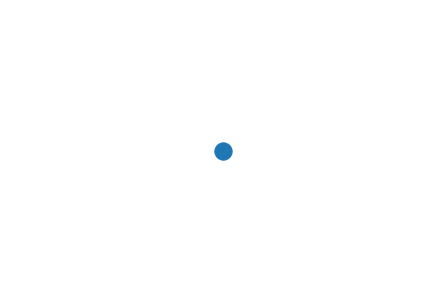

In [200]:
nx.draw(nx.complete_graph(1))

In [201]:
F = encoding.testGraph(nx.complete_graph(1), graph_name='c_3')
G = uts.from_networkx(nx.complete_graph(4))

G

Data(edge_index=[2, 12], num_nodes=4)

In [202]:
encoded_data = encoding.grandEmbedding(G)
encoded_data.clear_all_testgraphs()
encoded_data.add(F)
encoded_data.testgraphs

{<graph_encoding.encoding.testGraph at 0x136dc9990>}

In [203]:
dict_list = list(encoded_data.subIso(F))
converts = lambda x: dict_list[x]
maps = [(lambda x: dict[x]) for dict in dict_list]

test_edge_list = F.pyg_graph().edge_index.t()
test_edge_list


tensor([], size=(0, 2), dtype=torch.int64)

In [182]:
test_edge_tensor = torch.stack([test_edge_list.clone().apply_(lambda x: dict[x]) for dict in dict_list])
test_edge_tensor.size()

torch.Size([24, 6, 2])

In [196]:
x_ten = torch.tensor([[1,0,0], [1,1,1], [1,1,0], [1,1,1]] )

x_all = x_ten[test_edge_tensor]

x_all[0]

tensor([[[1, 0, 0],
         [1, 1, 1]],

        [[1, 0, 0],
         [1, 1, 0]],

        [[1, 1, 1],
         [1, 0, 0]],

        [[1, 1, 1],
         [1, 1, 0]],

        [[1, 1, 0],
         [1, 0, 0]],

        [[1, 1, 0],
         [1, 1, 1]]])

In [198]:
result = torch.prod(x_all, dim=-2)
#result.size()

suming = torch.sum(result, dim = -2)
suming.size()

torch.Size([24, 3])

In [199]:
d = dict()
len(d)

0

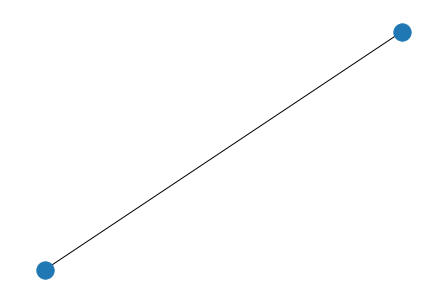

In [209]:
encoded_data.clear_all_testgraphs()
encoded_data.add_trees(stop = 3)
tree = list(encoded_data.testgraphs)[0]

tree.draw()